In [1]:
import pandas as pd
import seaborn as sns
import igraph
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

# import local functions
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from functions.author_fns import Author, compare_nets

%matplotlib inline

## Load data

In [2]:
method = 'florida'
node_2_gender = np.load('%s/data/%s_node_2_gender.npy'%('..',method),allow_pickle='TRUE').item()
g = igraph.load('../data/florida_coa_graph',format='pickle')

## Parameter distributions and constants

#### Thresholds and constants

In [3]:
nAuth = 1000
learn_thr = .1
c = 3
diam = 3
net_size = 500
bib_length = 100
woman_perc = sum([x['gender'] == 'woman' for x in node_2_gender.values()])/len(node_2_gender)
colors = ['#d97d5b', '#4a3b90']

#### Netbias
Max shows that coauthorship is a modest predictor of over/under citation

In [4]:
# parameters (mean, stdev) for each distribution
net_w = (.5,.1)
net_m = (.4,.1)

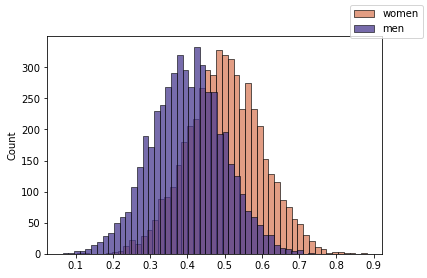

In [5]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=net_w[0],scale=net_w[1],size=5000), color=colors[0])
sns.histplot(np.random.normal(loc=net_m[0],scale=net_m[1],size=5000), color=colors[1])
f.legend(labels=['women','men'])

#### Walk bias
Taken from jordans paper, men cite WW teams about 20% less than you would expect. Women are about 5%

In [6]:
walk_w = (.5,.05)
walk_m = (.35,.05)

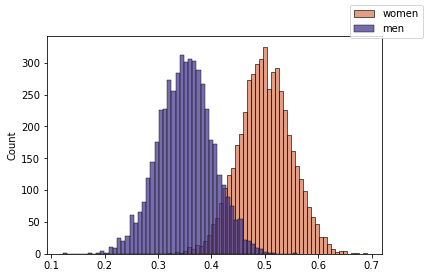

In [7]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=walk_w[0],scale=walk_w[1],size=5000), color=colors[0])
sns.histplot(np.random.normal(loc=walk_m[0],scale=walk_m[1],size=5000), color=colors[1])
f.legend(labels=['women','men'])

#### Meet bias
People in the majority are less interdisciplinary

In [8]:
meet_w = (0.02,0.005)
meet_m = (0.03,0.005)

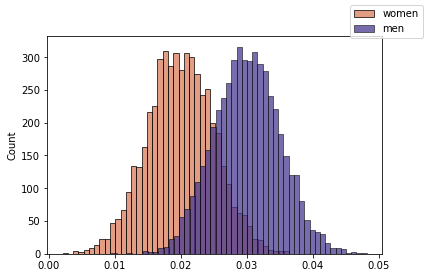

In [9]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=meet_w[0],scale=meet_w[1],size=5000), color=colors[0])
sns.histplot(np.random.normal(loc=meet_m[0],scale=meet_m[1],size=5000), color=colors[1])
f.legend(labels=['women','men'])

#### Learn bias
Taken from Chris's paper

In [10]:
learn_w = (-1,.75)
learn_m = (-1,.75)

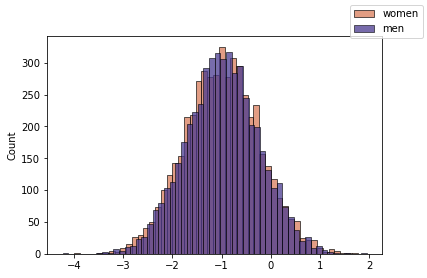

In [11]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.log(np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=5000)), color=colors[0])
sns.histplot(np.log(np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=5000)), color=colors[1])
f.legend(labels=['women','men'])

## Simulations


In [12]:
# generate authors
authors = []
for i in range(nAuth):
    if np.random.rand(1)[0] >= woman_perc:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gen)
    a.init_network(g,node_2_gender,net_size,diam,c)
    authors.append(a)


In [ ]:
# simulate meetings
nMeetings = 10000
meets = {}; # keep track of when meetings were successful
citation_perc = [];
citation_perc_w = [];
citation_perc_m = [];
w_index = [a.gender == 'W' for a in authors]
# run simulation
for i in tqdm(range(nMeetings)):
    # draw random authors
    auths = np.random.choice(range(nAuth),2)
    
    # check if at least one will meet
    [m12,m21] = compare_nets(authors[auths[0]], authors[auths[1]])
    if any([m12,m21]):
        # if yes, update the network
        if m12:
            bib = authors[auths[1]].get_cites(bib_length)
            authors[auths[0]].update_network(bib, authors[auths[1]].network, learn_thr)
        if m21:
            bib = authors[auths[0]].get_cites(bib_length)
            authors[auths[1]].update_network(bib, authors[auths[0]].network, learn_thr)
    # log information
    # update meets
    meets[i] = {'gender': authors[auths[0]].gender + authors[auths[1]].gender, 'meet':[m12,m21]}
    # update cites
    bibs = [a.get_cites(bib_length) for a in authors]
    bibs_w = [b for i,b in enumerate(bibs) if w_index[i]]
    bibs_m = [b for i,b in enumerate(bibs) if not(w_index[i])]
    citation_perc.append(np.mean([cite['gender'] == 'woman' for b in bibs for cite in b.values()]))
    citation_perc_w.append(np.mean([cite['gender'] == 'woman' for b in bibs_w for cite in b.values()]))
    citation_perc_m.append(np.mean([cite['gender'] == 'woman' for b in bibs_m for cite in b.values()]))
    

 14%|█▍        | 1386/10000 [2:13:00<13:47:46,  5.77s/it]

In [ ]:
# plots
sns.countplot([sum(x['meet']) for x in meets.values()])

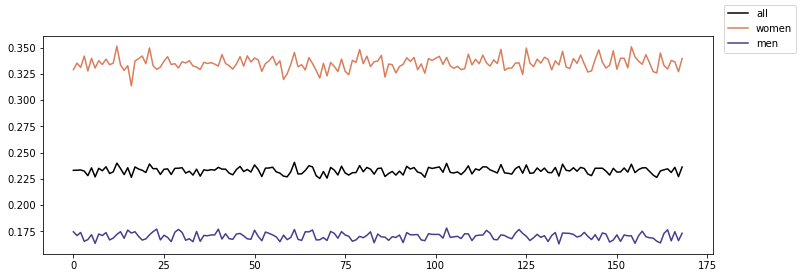

In [15]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=citation_perc, color='k',ax=ax)
sns.lineplot(data=citation_perc_w, color=colors[0],ax=ax)
sns.lineplot(data=citation_perc_m, color=colors[1],ax=ax)
f.legend(labels=['all','women','men'])